# Исследование технологического процесса очистки золота

### Описание проекта
Строится модель машинного обучения для промышленной компании, разрабатывающей решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды на основе данных с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

### План проекта

    1. Загрузка и подготовка данных
    2. Предобработка данных
    3. Анализ данных
       3.1. Определим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки
       3.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках
       3.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах
    4. Построение модели
    5. Общие выводы

### Описание данных
Данные находятся в трёх файлах: обучающая выборка, тестовая выборка и исходные данные. Данные индексируются датой и временем получения информации. Соседние по времени параметры часто похожи. Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков. Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

### 1. Загрузка и подготовка данных

In [1]:
#загрузка необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
#загружаем датсеты
try:
    gold_recovery_train = pd.read_csv('gold_recovery_train_new.csv')
except:
    gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    
try:
    gold_recovery_test = pd.read_csv('gold_recovery_test_new.csv')
except:
    gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test_new.csv') 
    
try:
    gold_recovery_full = pd.read_csv('gold_recovery_full_new.csv')
except:
    gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Подробнее рассмотрим данные с обучающей выборкой:

In [3]:
#выведем первые 10 строк:
gold_recovery_train.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


In [4]:
#общая информация о данных:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Подробнее расммотрим данные из тестовой выборки:

In [5]:
#выведем первые 10 строк:
gold_recovery_test.head(10)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
5,2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
6,2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
7,2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
8,2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716
9,2016-09-01 09:59:59,126.961069,8.017856,7.030000,0.805298,1400.816120,-499.014158,1399.975401,-499.570552,1401.871924,...,12.040725,-499.987743,7.989503,-499.750625,7.989710,-509.946737,5.068811,-499.293900,24.992741,-499.272255


In [6]:
#общая информация о данных:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Подробнее рассмотрим исходные данные:

In [7]:
#выведем первые 10 строк:
gold_recovery_full.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


In [8]:
#общая информация о данных:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [9]:
# определим эффективность обогащения на этапе флотации по формуле:
rougher_recovery = 100*(gold_recovery_train['rougher.output.concentrate_au']* \
                    (gold_recovery_train['rougher.input.feed_au']-gold_recovery_train['rougher.output.tail_au']))/ \
                    (gold_recovery_train['rougher.input.feed_au']* \
                    (gold_recovery_train['rougher.output.concentrate_au']-gold_recovery_train['rougher.output.tail_au']))

In [10]:
# определим MAE между расчётами и значением признака:
mean_absolute_error(rougher_recovery, gold_recovery_train['rougher.output.recovery'])

1.1131451184435918e-14

In [11]:
#определим признаки, отсутcтвующиие в тестовой выборке:
missing_columns =[]
for name in  gold_recovery_train.columns:
    if name not in gold_recovery_test.columns:
        missing_columns.append(name)

In [12]:
missing_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

### Выводы:
    1) Ознакомились с предоставленными данными: в таблице с обучающей выборке предоставлены данные о 87 признаков 14149 измерений, в таблице с тестовой выборкой - данные о 53 признаках 5290 измерений, в общей таблице - 87 признаков 19439 измерений.
    2) Создали функцию для расчета эффективности обогащения, вычислили на обучающей выборке для чернового концетрата, затем вычислили MAE между расчётами и значением признака. Полученное значение MAE (1.1131451184435918e-14) близко к 0, значение признака расчитано верно.
    3) В тестовой выборке недоступны признаки, которые замеряются и/или рассчитываются значительно позже (онлайн признаки)

### 2. Предобработка данных

In [13]:
#изменим тип данных для столбцов data во всех датафремах:
gold_recovery_train['date'] = pd.to_datetime(gold_recovery_train['date'], format='%Y-%m-%d %H:%M:%S')
gold_recovery_test['date'] = pd.to_datetime(gold_recovery_test['date'], format='%Y-%m-%d %H:%M:%S')
gold_recovery_full['date'] = pd.to_datetime(gold_recovery_full['date'], format='%Y-%m-%d %H:%M:%S')

In [14]:
#проверим на наличие дубликатов:
print(gold_recovery_train.duplicated().sum(), gold_recovery_test.duplicated().sum(), gold_recovery_full.duplicated().sum())

0 0 0


Проведем предобработку данных для обучающей выборки:

In [15]:
# исключим столбцы, отутствующие в тестовой выборке, и вернем целевые признаки:
name_columns = list(gold_recovery_test.columns)
name_columns.extend(['final.output.recovery', 'rougher.output.recovery'])
gold_recovery_train = gold_recovery_train[name_columns]

In [16]:
#проверим столбцы
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        14149 non-null  datetime64[ns]
 1   primary_cleaner.input.sulfate               14129 non-null  float64       
 2   primary_cleaner.input.depressant            14117 non-null  float64       
 3   primary_cleaner.input.feed_size             14149 non-null  float64       
 4   primary_cleaner.input.xanthate              14049 non-null  float64       
 5   primary_cleaner.state.floatbank8_a_air      14145 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_level    14148 non-null  float64       
 7   primary_cleaner.state.floatbank8_b_air      14145 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_level    14148 non-null  float64       
 9   primar

In [17]:
#определим количество пропусков для каждого столбца:
gold_recovery_train.isna().sum()

date                                            0
primary_cleaner.input.sulfate                  20
primary_cleaner.input.depressant               32
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                100
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_b_level        1
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_c_level        1
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_rate                         8
rougher.input.feed_size                       144
rougher.input.feed_sol                         78
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate              29


Есть столбцы с достаточно большим количеством пропущенных значений. Так как по данным установить зависимость между параметрами достаточно сложно, а удалять такое количество измерений не хотелось бы, то: 1) удаляем измерения, где есть пропуски в столбцах с малым количеством пропусков 2) для столбцов с большим количеством пропусков пропущенные значения восстановим с помощью интерполяции соседних по дате (так как в условии было сказано, что соседние измерения чаще всего близки по велечине)
Для того, чтобы провести  интрполяцию, необходимы последовательные измерения, поэтому пропуски будем заполять в датафрейме со всеми исходыми данными

In [18]:
#посомтрим на количество пропусков в интересующих нас столбцах:
gold_recovery_full[name_columns].isna().sum()

date                                            0
primary_cleaner.input.sulfate                  24
primary_cleaner.input.depressant               37
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                104
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_b_level        1
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_c_level        1
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_rate                        11
rougher.input.feed_size                       145
rougher.input.feed_sol                         99
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate              34


Определим отсутствующие значения интерполяцией по соседним только для столбцов, в которых пропущенных значений больше или равно 99

In [19]:
#проверим, что в исходных данных измерения расположены по возрастанию даты
(gold_recovery_full['date'] == gold_recovery_full.sort_values(by='date')['date']).sum()

19439

In [20]:
#определим столбцы, в которх пропусков больше или равно 99:
name_columns_interpolate = []
for i in name_columns:
    if gold_recovery_full[i].isna().sum() > 98:
        name_columns_interpolate.append(i)

In [21]:
name_columns_interpolate

['primary_cleaner.input.xanthate',
 'rougher.input.feed_pb',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_e_air',
 'secondary_cleaner.state.floatbank2_a_air']

In [22]:
# заполним пропущенные значения в определенных ранее столбцах интерполяцией:
for i in name_columns_interpolate:
    gold_recovery_full[i] = gold_recovery_full[i].interpolate()

In [23]:
# проверим, что заполнили пропуски:
gold_recovery_full[name_columns_interpolate].isna().sum()

primary_cleaner.input.xanthate              0
rougher.input.feed_pb                       0
rougher.input.feed_size                     0
rougher.input.feed_sol                      0
rougher.input.floatbank11_xanthate          0
rougher.state.floatbank10_e_air             0
secondary_cleaner.state.floatbank2_a_air    0
dtype: int64

Вернемся  к обучающей и тестовой выборкам и заполним пропуски в указанных столбцах из gold_recovery_full:

In [24]:
# для корректной замены используем столбец с датой вместо индекса:
gold_recovery_full.set_index('date', inplace=True)
gold_recovery_train.set_index('date', inplace=True)
gold_recovery_test.set_index('date', inplace=True)

In [25]:
# заменим пропущенные значения в обучающей и тестовых выборках из gold_recovery_full:
for colum in name_columns_interpolate:
    for i in gold_recovery_train[gold_recovery_train[colum].isnull()].index:
        gold_recovery_train.loc[i, colum] = gold_recovery_full.loc[i, colum]
    for i in gold_recovery_test[gold_recovery_test[colum].isnull()].index:
        gold_recovery_test.loc[i, colum] = gold_recovery_full.loc[i, colum]

In [26]:
# проверим:
print (gold_recovery_train[name_columns_interpolate].isna().sum().sum(), \
       gold_recovery_test[name_columns_interpolate].isna().sum().sum())

0 0


In [27]:
#определим долю оставшихся пропущенных значений в выборках:
print(gold_recovery_train.isna().sum().sum()/gold_recovery_train.shape[0])
print(gold_recovery_test.isna().sum().sum()/gold_recovery_test.shape[0])

0.014276627323485759
0.006805293005671078


In [28]:
gold_recovery_train.isna().sum().sum()

202

In [29]:
gold_recovery_test.isna().sum().sum()

36

In [30]:
gold_recovery_train.shape[0]

14149

In [31]:
gold_recovery_test.shape[0]

5290

In [32]:
#удаляем измерения с пропущенными значениями из обучающей и тестовой выборок:
gold_recovery_train = gold_recovery_train.dropna()
gold_recovery_test = gold_recovery_test.dropna()

In [33]:
#проверяем отсутствие пропусков для обучающей выборки:
gold_recovery_train.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

In [34]:
#проверяем отсутствие пропусков для тестовой выборки:
gold_recovery_test.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

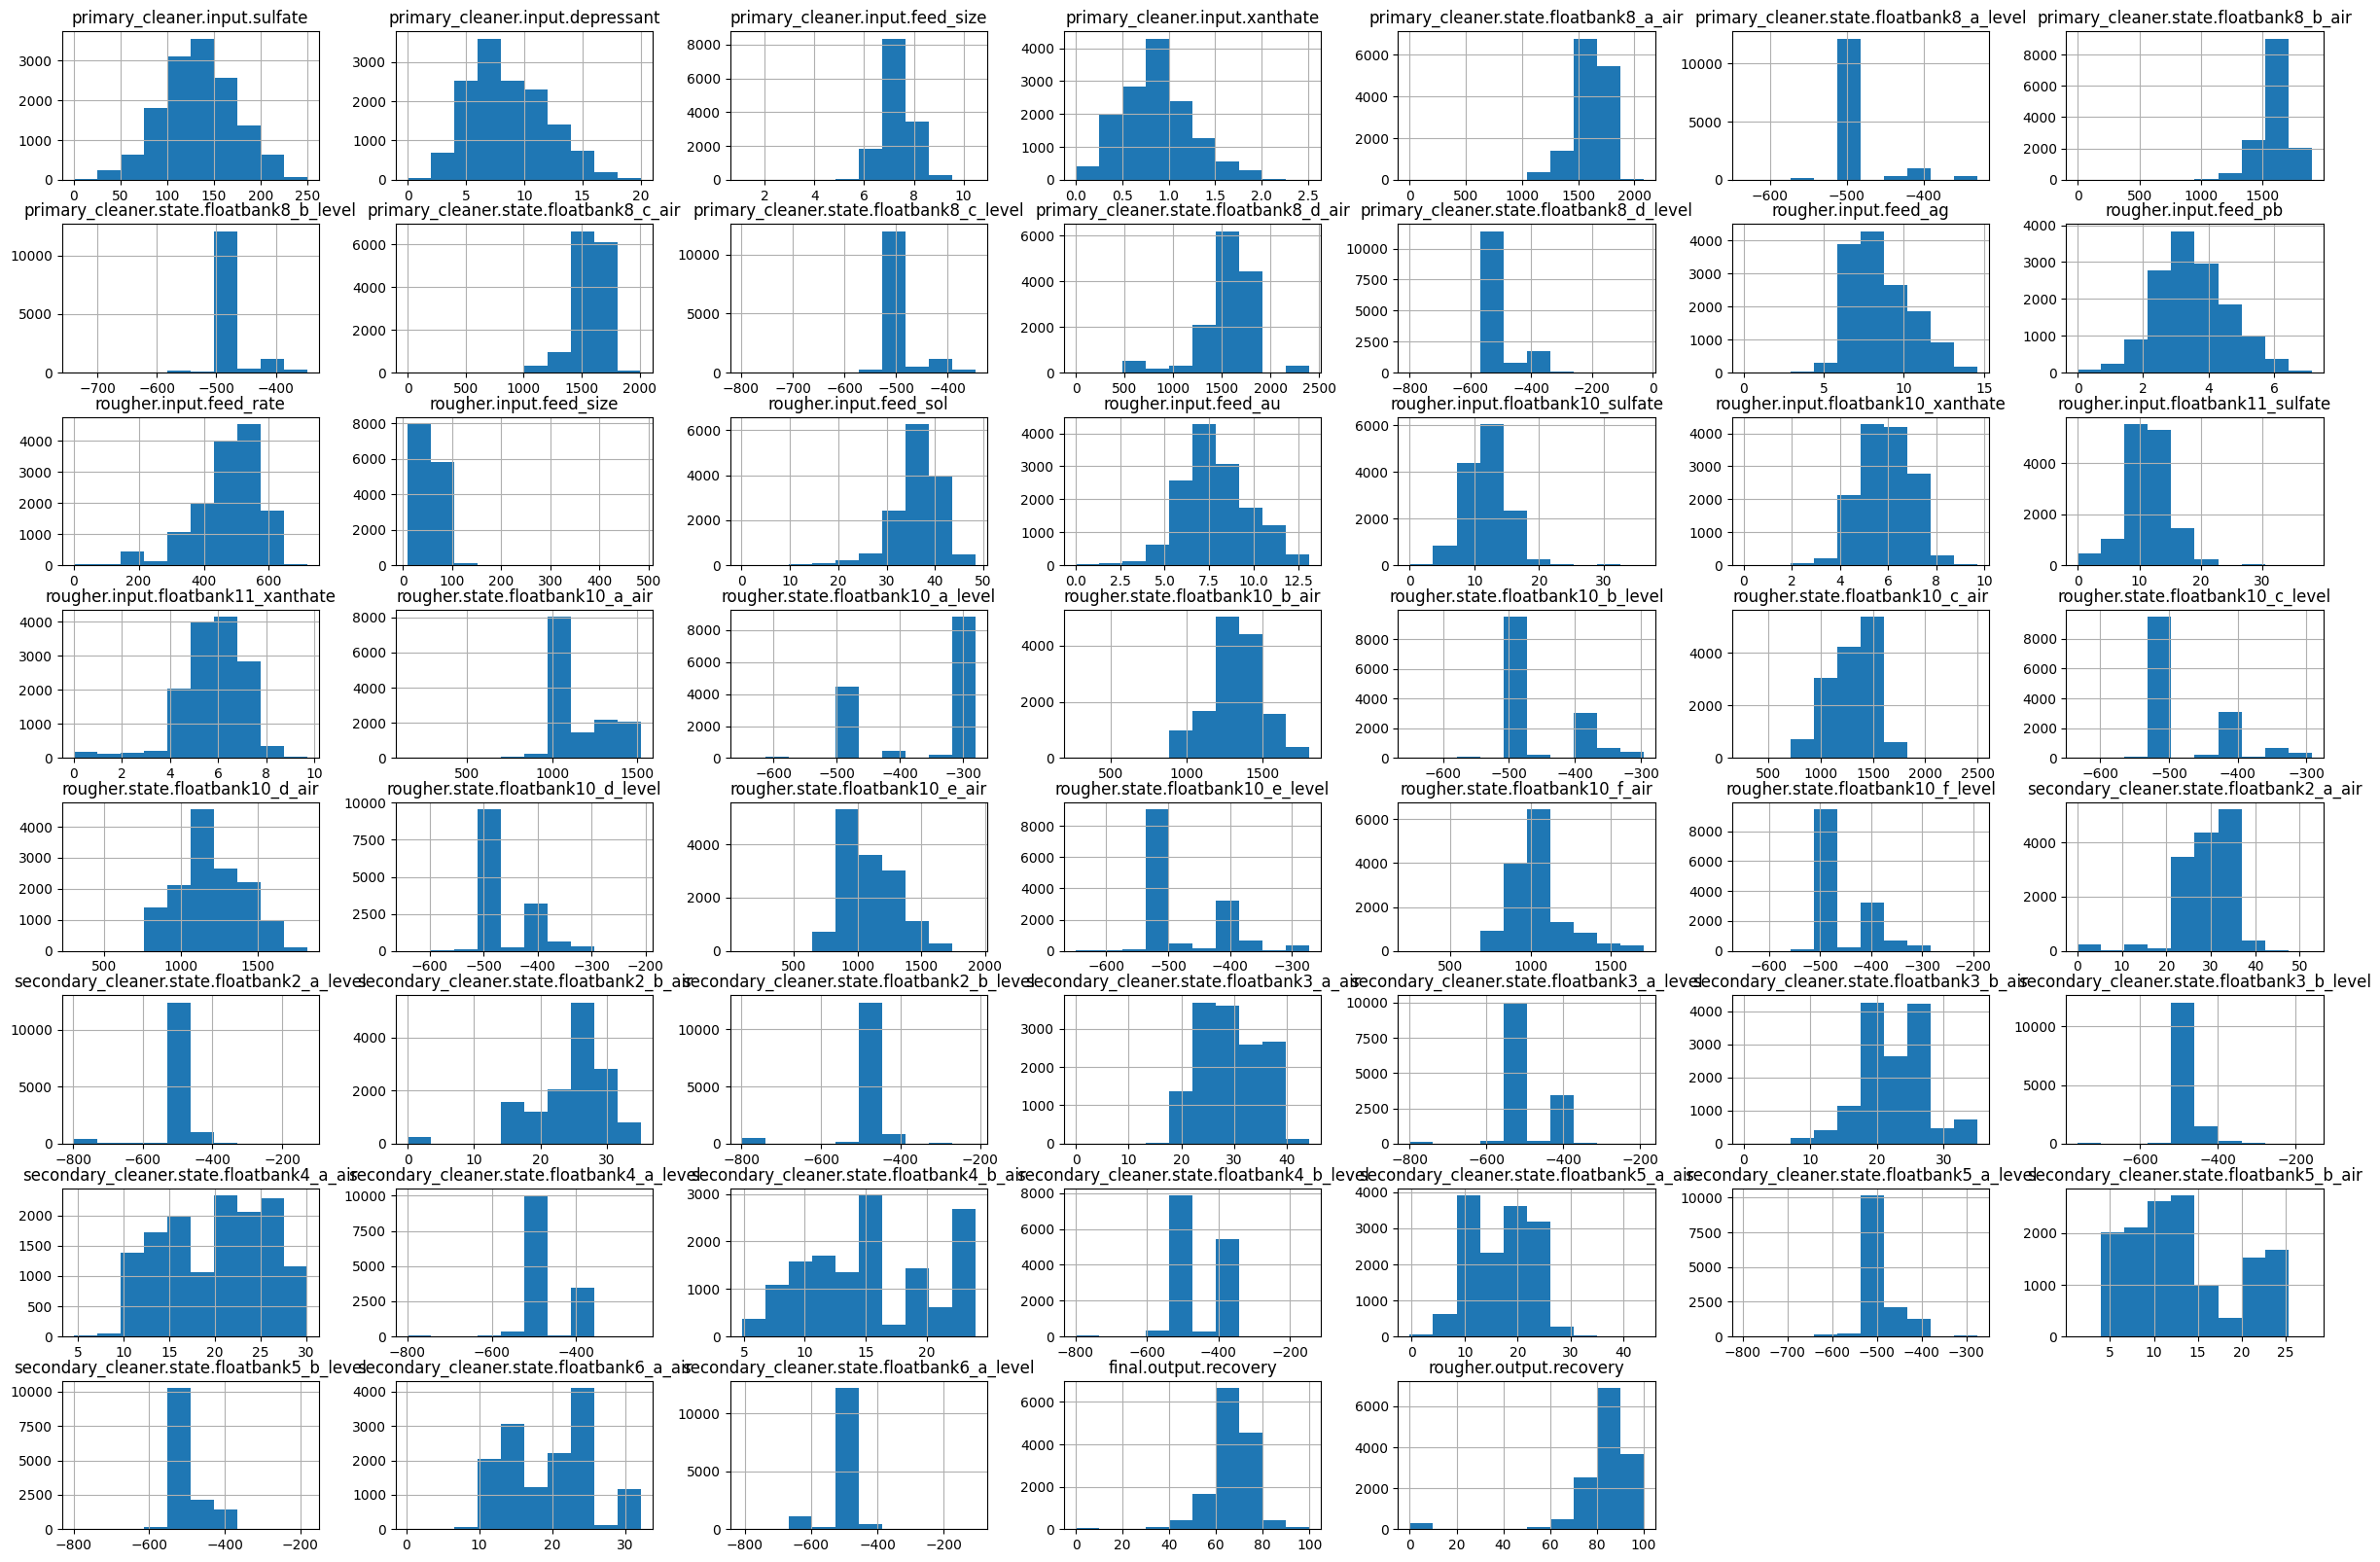

In [35]:
#гистограммы обучающей выборки
gold_recovery_train.hist(figsize=(30,20));

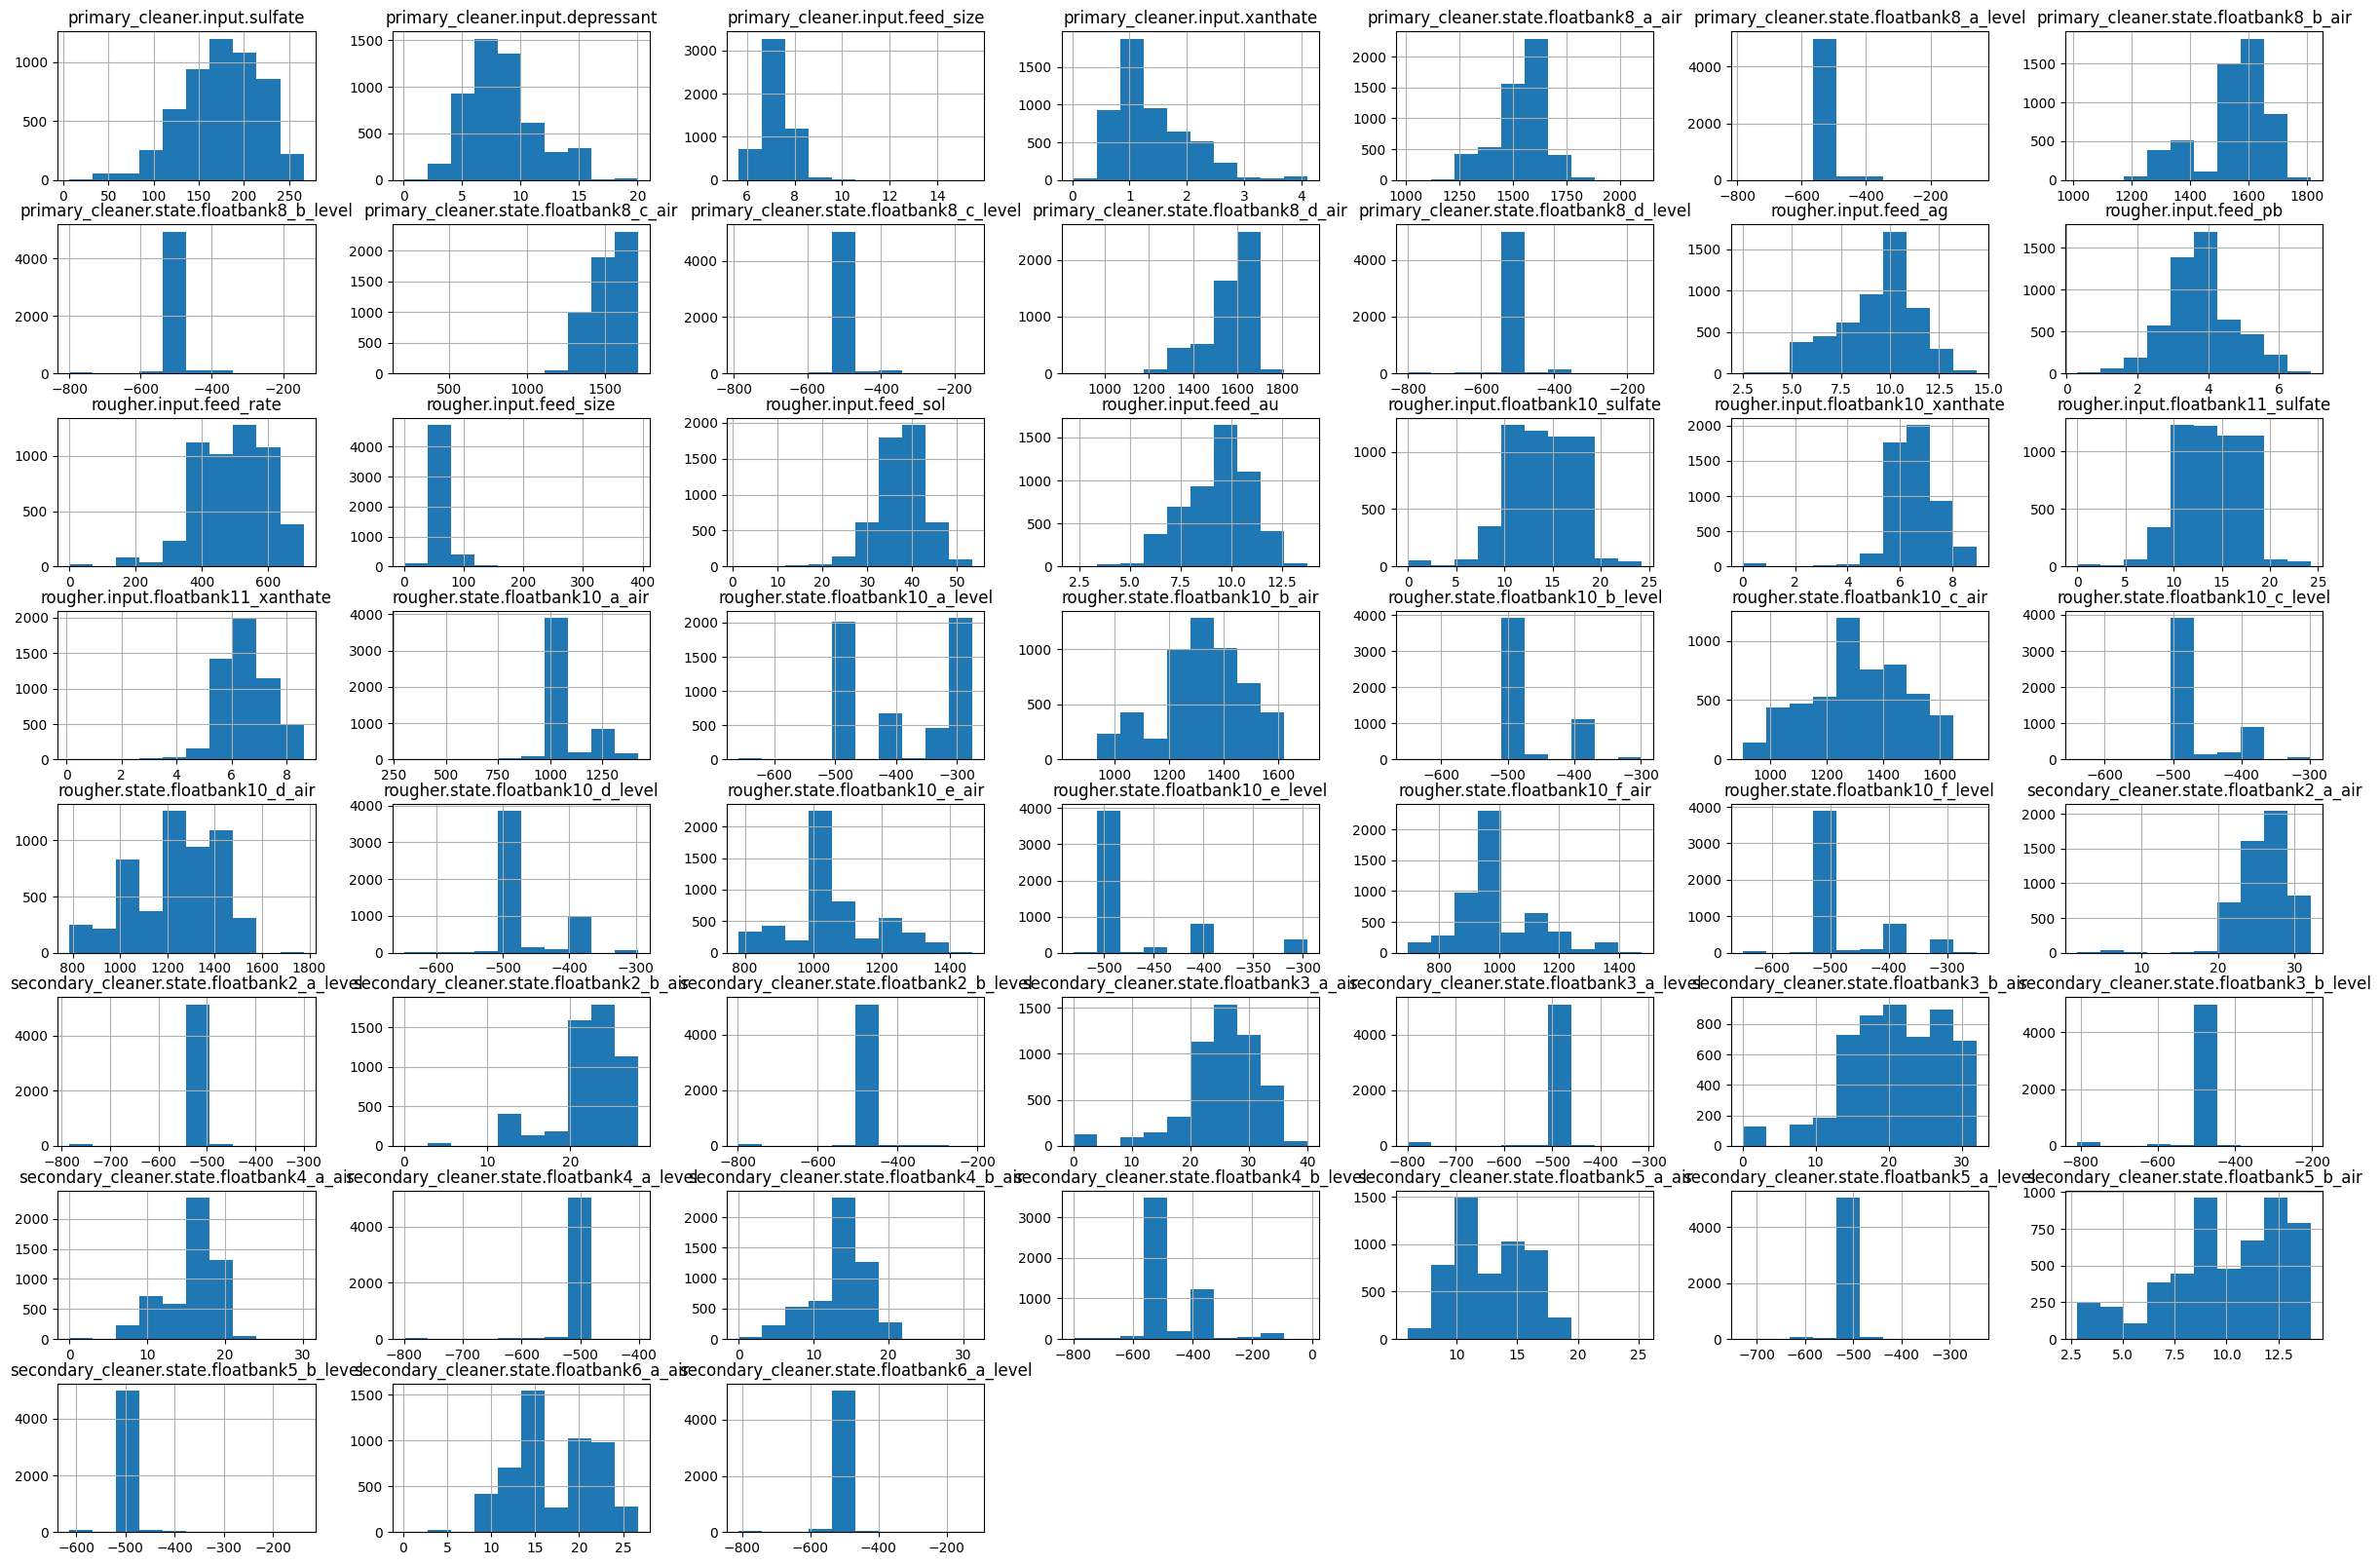

In [36]:
#гистограммы тестовой выборки
gold_recovery_test.hist(figsize=(30,20));

In [37]:
#добавим в тестовую выборку столбцы с целевыми признаками:
gold_recovery_test['rougher.output.recovery'] = gold_recovery_full.loc[gold_recovery_test.index, 'rougher.output.recovery']
gold_recovery_test['final.output.recovery'] = gold_recovery_full.loc[gold_recovery_test.index, 'final.output.recovery']

### Выводы:
    1) Изменили тип данных в столце, с указанием времени измерения
    2) Дубликаты в данных отсутствуют
    3) Оставили в обучающей выборке только признаки, указанные в тестовой выборке, и целевые признаки
    4) В тестовую выборку добавили целевы признаки
    5) Определили наличие пропусков, проверили, что исходный датасет содержит измерения, отсортированные по времени, интерполировали пропуски в столбцах с количеством пропусков, превышающих 100 (так как в исходных данных указано, что близкие по времени измерения имею схожие значения признаков)
    6) Остальные пропуски исключили
    7) Обработали пропуски в обучающей и тестовой выборках

### 3. Анализ данных

**3.1. Определим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки**

In [38]:
# определим названия столбцов, определяющих концентрацию металлов (Au, Ag, Pb) на различных этапах очистки:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

для Au - rougher.input.feed_au - для исходной смеси, rougher.output.concentrate_au - для чернового концентрата, final.output.concentrate_au - для финального концентрата;
для Ag:rougher.input.feed_ag - для исходной смеси, rougher.output.concentrate_ag - для чернового концентрата, final.output.concentrate_ag - для финального концентрата;
для Pb:rougher.input.feed_pb - для исходной смеси, rougher.output.concentrate_pb - для чернового концентрата, final.output.concentrate_pb - для финального концентрата

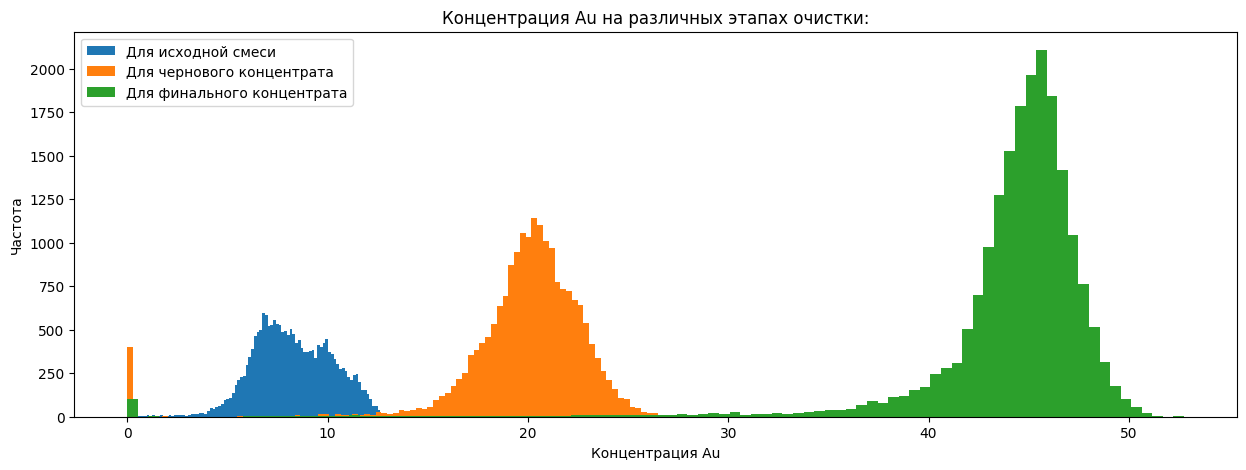

In [39]:
#построим гистограммы для разных этапов очистки для Au:
fig, ax = plt.subplots(figsize=(15,5))
rec1 = ax.hist(gold_recovery_full['rougher.input.feed_au'], bins=100, label='Для исходной смеси')
rec2 = ax.hist(gold_recovery_full['rougher.output.concentrate_au'], bins=100, label='Для чернового концентрата')
rec3 = ax.hist(gold_recovery_full['final.output.concentrate_au'], bins=100, label='Для финального концентрата')
ax.set(title='Концентрация Au на различных этапах очистки:', ylabel='Частота', xlabel='Концентрация Au')
ax.set()
ax.legend();

Из диаграммы видно, что в данных присутстуют измерения, при которых концентрация Au равно 0. Подробнее рассмотрим данные измерения:

In [40]:
#определим, есть ли измерения с нулевым значением концентраци Au для исходной смеси:
gold_recovery_full[gold_recovery_full['rougher.input.feed_au']==0]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,


In [41]:
#определим, есть ли измерения с нулевым значением концентраци Au для чернового концентрата:
gold_recovery_full[gold_recovery_full['rougher.output.concentrate_au']==0]['rougher.output.concentrate_au'].count()

394

C учетом того, что судя по диаграмме для большинства измерений концетрация Au увеличилась, возникает вопрос о данных измерениях. Для наших моделей концентрация не будет участвовать в определении эффективности обогащения, однако стоит проверить для данных измерений не является ли 0 вычисленная эффективность обогащения?

In [42]:
#определим, совпадают ли нулевые значения в столбцах с указанием концентрации Au и эффективностью обогащения на этапе чернового концентрата
gold_recovery_full[(gold_recovery_full['rougher.output.concentrate_au']==0)&\
                   (gold_recovery_full['rougher.output.recovery']==0)]['rougher.output.recovery'].count()

394

Вывод: данные измерения некорректные и их необходимо исключить, причем не только в исходных данных, но и в обучающей и тестовой выборках, поэтому сначала проверим, все ли нули в столбце rougher.output.recovery необходимо удалять:

In [43]:
#определям количество 0 в столбце rougher.output.recovery:
gold_recovery_full[gold_recovery_full['rougher.output.recovery']==0]['rougher.output.recovery'].count()

394

In [44]:
#исключаем некорректные данные из gold_recovery_full, а также из обучающей и тестовой выборок:
gold_recovery_full = gold_recovery_full[gold_recovery_full['rougher.output.recovery']!=0]
gold_recovery_train = gold_recovery_train[gold_recovery_train['rougher.output.recovery']!=0]
gold_recovery_test = gold_recovery_test[gold_recovery_test['rougher.output.recovery']!=0]

In [45]:
#проверяем наличие 0 в концентрации Au для финального концентрата:
gold_recovery_full[gold_recovery_full['final.output.concentrate_au']==0]['final.output.concentrate_au'].count()

96

In [46]:
#определим, совпадают ли нулевые значения в столбцах с указанием концентрации Au и эффективностью обогащения на этапе финального концентрата
gold_recovery_full[(gold_recovery_full['final.output.concentrate_au']==0)&\
                   (gold_recovery_full['final.output.recovery']==0)]['final.output.recovery'].count()

96

In [47]:
#определям количество 0 в столбце final.output.recovery:
gold_recovery_full[gold_recovery_full['final.output.recovery']==0]['final.output.recovery'].count()

96

In [48]:
#исключаем некорректные данные из gold_recovery_full, а также из обучающей и тестовой выборок:
gold_recovery_full = gold_recovery_full[gold_recovery_full['final.output.recovery']!=0]
gold_recovery_train = gold_recovery_train[gold_recovery_train['final.output.recovery']!=0]
gold_recovery_test = gold_recovery_test[gold_recovery_test['final.output.recovery']!=0]

In [49]:
#для корректного расчета функции smape проверим, не осталось ли 0 в значениях целевых признаков:
print(gold_recovery_full[gold_recovery_full['rougher.output.recovery']==0]['rougher.output.recovery'].count(),\
      gold_recovery_full[gold_recovery_full['final.output.recovery']==0]['final.output.recovery'].count())

0 0


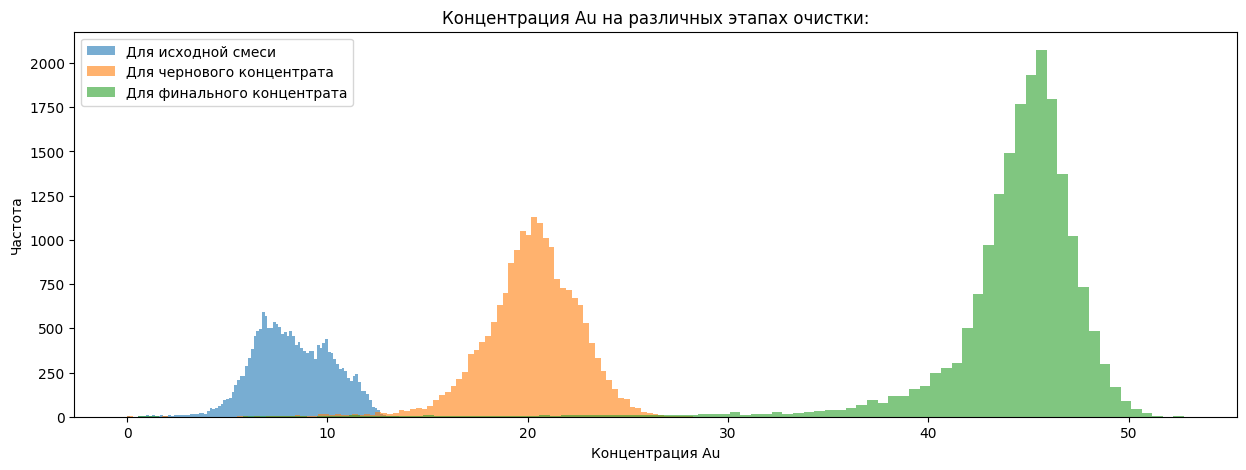

In [50]:
#построим гистограммы для разных этапов очистки для Au:
fig, ax = plt.subplots(figsize=(15,5))
rec1 = ax.hist(gold_recovery_full['rougher.input.feed_au'], alpha=0.6, bins=100, label='Для исходной смеси')
rec2 = ax.hist(gold_recovery_full['rougher.output.concentrate_au'], alpha=0.6, bins=100, label='Для чернового концентрата')
rec3 = ax.hist(gold_recovery_full['final.output.concentrate_au'], alpha=0.6,bins=100, label='Для финального концентрата')
ax.set(title='Концентрация Au на различных этапах очистки:', ylabel='Частота', xlabel='Концентрация Au')
ax.set()
ax.legend();

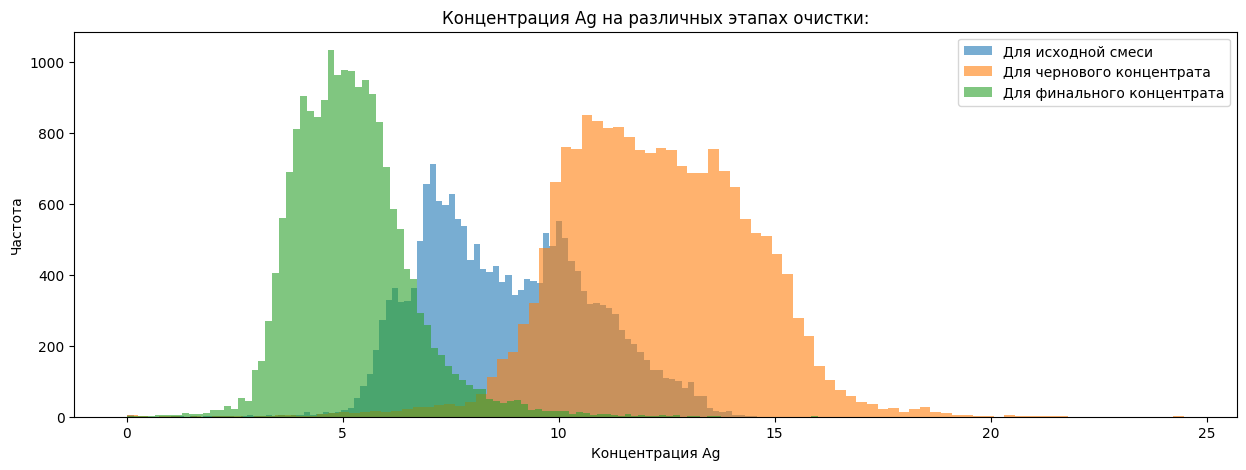

In [51]:
#построим гистограммы для разных этапов очистки для Ag:
fig, ax = plt.subplots(figsize=(15,5))
rec1 = ax.hist(gold_recovery_full['rougher.input.feed_ag'], bins=100, alpha=0.6, label='Для исходной смеси')
rec2 = ax.hist(gold_recovery_full['rougher.output.concentrate_ag'], bins=100, alpha=0.6, label='Для чернового концентрата')
rec3 = ax.hist(gold_recovery_full['final.output.concentrate_ag'], bins=100, alpha=0.6, label='Для финального концентрата')
ax.set(title='Концентрация Ag на различных этапах очистки:', ylabel='Частота', xlabel='Концентрация Ag')
ax.set()
ax.legend();

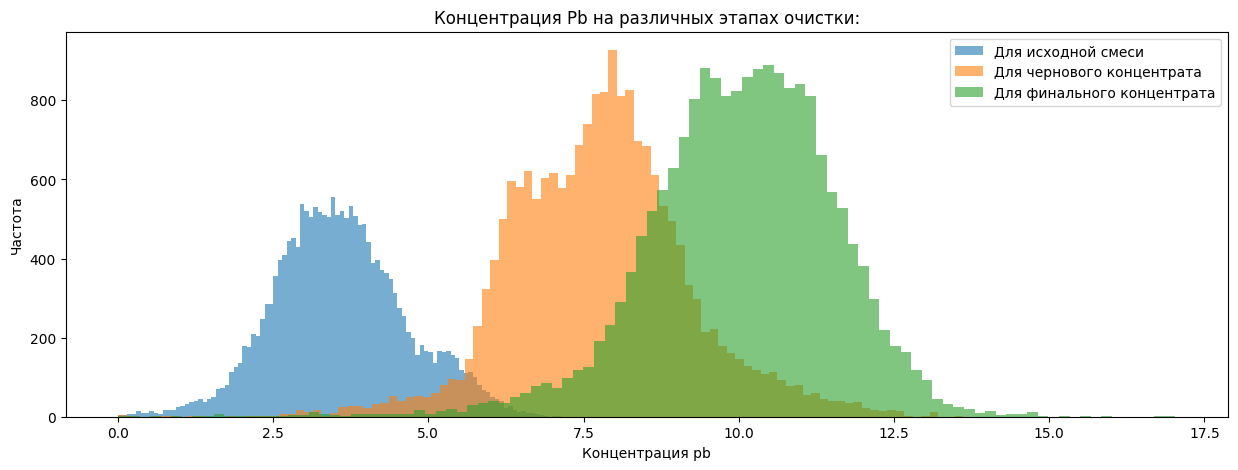

In [52]:
#построим гистограммы для разных этапов очистки для Pb:
fig, ax = plt.subplots(figsize=(15,5))
rec1 = ax.hist(gold_recovery_full['rougher.input.feed_pb'], bins=100, alpha=0.6, label='Для исходной смеси')
rec2 = ax.hist(gold_recovery_full['rougher.output.concentrate_pb'], bins=100, alpha=0.6, label='Для чернового концентрата')
rec3 = ax.hist(gold_recovery_full['final.output.concentrate_pb'], bins=100, alpha=0.6, label='Для финального концентрата')
ax.set(title='Концентрация Pb на различных этапах очистки:', ylabel='Частота', xlabel='Концентрация pb')
ax.set()
ax.legend();

**Выводы:**

    - Концентрация Au увеличивалась и после проведения флотации, и после этапов очистки
    - Концентрация Ag после флотации увеличилась, а после фильтрации уменьшилась и стала меньше исходной
    - Концентрация Pb увеличилась и после проведения флотации, и после этапов очистки

**3.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках**

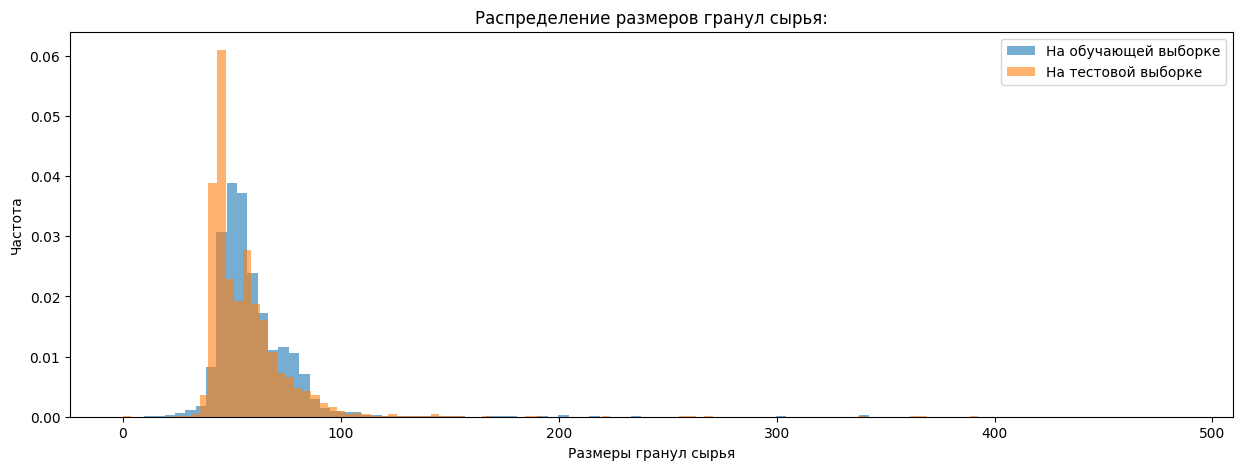

In [53]:
fig, ax = plt.subplots(figsize=(15,5))
rec1 = ax.hist(gold_recovery_train['rougher.input.feed_size'], density = True, bins=100, alpha=0.6, label='На обучающей выборке')
rec2 = ax.hist(gold_recovery_test['rougher.input.feed_size'], density = True, bins=100, alpha=0.6, label='На тестовой выборке')
ax.set(title='Распределение размеров гранул сырья:', ylabel='Частота', xlabel='Размеры гранул сырья')
ax.set()
ax.legend();

**Вывод**: Распределения размеров гранул сырья на обучающей и тестовой выборках имеют схожие формы, однако в тестовой выборке наблюдаются более ярко выраженные пиковые значения, что объясняется меньшим количеством измерений.

**3.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах**

In [54]:
#добавим в gold_recovery_full столбцы с суммарной концентрацией всех веществ на разных стадиях:
#для сырья
gold_recovery_full['rougher.input.feed_sum'] = gold_recovery_full['rougher.input.feed_au']+\
                                gold_recovery_full['rougher.input.feed_ag']+gold_recovery_full['rougher.input.feed_pb']+\
                                gold_recovery_full['rougher.input.feed_sol']
#для чернового концентрата
gold_recovery_full['rougher.output.concentrate_sum'] = gold_recovery_full['rougher.output.concentrate_au']+\
                                gold_recovery_full['rougher.output.concentrate_ag']+gold_recovery_full['rougher.output.concentrate_pb']+\
                                gold_recovery_full['rougher.output.concentrate_sol']
#для финального концентрата
gold_recovery_full['final.output.concentrate_sum'] = gold_recovery_full['final.output.concentrate_au']+\
                                gold_recovery_full['final.output.concentrate_ag']+gold_recovery_full['final.output.concentrate_pb']+\
                                gold_recovery_full['final.output.concentrate_sol']

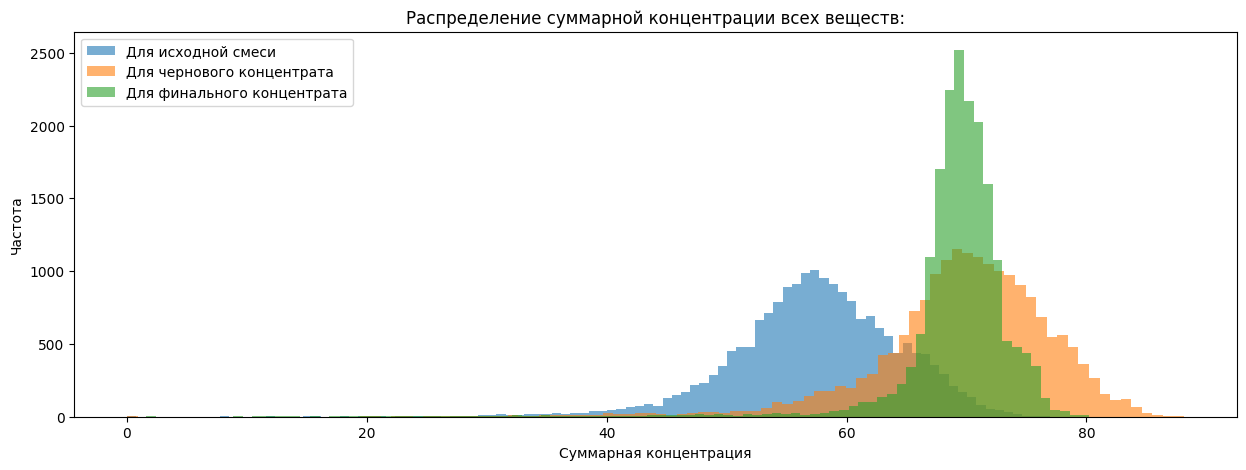

In [55]:
#построим соответствующие гистограммы:
fig, ax = plt.subplots(figsize=(15,5))
rec1 = ax.hist(gold_recovery_full['rougher.input.feed_sum'], bins=100, alpha=0.6, label='Для исходной смеси')
rec2 = ax.hist(gold_recovery_full['rougher.output.concentrate_sum'], bins=100, alpha=0.6, label='Для чернового концентрата')
rec3 = ax.hist(gold_recovery_full['final.output.concentrate_sum'], bins=100, alpha=0.6, label='Для финального концентрата')
ax.set(title='Распределение суммарной концентрации всех веществ:', ylabel='Частота', xlabel='Суммарная концентрация')
ax.set()
ax.legend();

**Вывод:** Суммарная концентрация всех веществ на разных стадиях: в черновом концентрате увеличилась, а в финальном - уменьшился раброс значений

In [56]:
# определим столбцы, которые будут признаками для построения модели, предсказывающей эффективность обогащения после флотации:
name_columns_rougher = []
for name in gold_recovery_test.columns:
    if 'rougher' in name.split('.'):
        name_columns_rougher.append(name)

In [57]:
# определим признаки и целевой признак для обучающей выборки:
final_recovery_features_train = gold_recovery_train[gold_recovery_test.columns].drop(axis=1, columns=['rougher.output.recovery', 'final.output.recovery']).reset_index(drop=True)
final_recovery_target_train = gold_recovery_train['final.output.recovery'].reset_index(drop=True)
rougher_recovery_features_train = gold_recovery_train[name_columns_rougher].drop(axis=1, columns=['rougher.output.recovery']).reset_index(drop=True)
rougher_recovery_target_train = gold_recovery_train['rougher.output.recovery'].reset_index(drop=True)

In [58]:
# определим признаки и целевой признак для тестовой выборки:
final_recovery_features_test = gold_recovery_test.drop(axis=1, columns=['rougher.output.recovery', 'final.output.recovery']).reset_index(drop=True)
final_recovery_target_test = gold_recovery_test['final.output.recovery'].reset_index(drop=True)
rougher_recovery_features_test = gold_recovery_test[name_columns_rougher].drop(axis=1, columns=['rougher.output.recovery']).reset_index(drop=True)
rougher_recovery_target_test = gold_recovery_test['rougher.output.recovery'].reset_index(drop=True)

In [59]:
# проверка размерности:
print(final_recovery_features_train.shape, final_recovery_target_train.shape)
print(final_recovery_features_test.shape, final_recovery_target_test.shape)

(13701, 52) (13701,)
(5139, 52) (5139,)


In [60]:
# проверка размерности:
print(rougher_recovery_features_train.shape, rougher_recovery_target_train.shape)
print(rougher_recovery_features_test.shape, rougher_recovery_target_test.shape)

(13701, 22) (13701,)
(5139, 22) (5139,)


### Выводы:
    1) В ходе анализа изменения концентраций металлов были выявлены некорректные измерения и исключены для дальнейшего анализа
    2) Концентрация Au увеличивалась и после проведения флотации, и после этапов очистки
    3) Концентрация Ag после флотации увеличилась, а после фильтрации уменьшилась и стала меньше исходной
    4) Концентрация Pb увеличилась и после проведения флотации, и после этапов очистки
    5) Распределения размеров гранул сырья на обучающей и тестовой выборках имеют схожие формы
    6) Суммарная концентрация всех веществ на разных стадиях: в черновом концентрате увеличилась, а в финальном - уменьшился раброс значений
    7) Выделили признаки и целевые признаки для обучения моделей, предсказывающих эффективность обогащения на этапах чернового и итогового концентратов

### 4. Построение модели

In [61]:
#функция для вычисления sMAPE
def smape(target, predicted):
    target, predicted = np.array(target), np.array(predicted)
    return np.mean(np.abs(predicted - target) / 
            ((np.abs(predicted) + np.abs(target))/2)
               )*100

In [62]:
#чтобы можно было использовать дальше
smape_scorer = make_scorer(smape, greater_is_better=False)

In [63]:
#функция для вычисления итогового sMAPE:
def smape_final(smape_rougher, smape_final):
    return 0.25*smape_rougher+0.75*smape_final

In [64]:
#содание таблицы для хранения вычисленных smape для моделей:
smape_tabl = pd.DataFrame(0, index=['rougher', 'final'], columns=['linear', 'tree', 'forest'])

In [65]:
#создадим функцию для обучения модели линейной регрессии для предсказания эффективности обогащения:
def linear_regression_recovery(features, target):
    #стандартизируем признаки:
    scaler = StandardScaler()
    scaler.fit(features)
    features_scaler = scaler.transform(features)
    #обучаем модель
    model = LinearRegression()
    score = cross_val_score(model, features_scaler, target, cv=5, scoring=smape_scorer)
    return scaler, score

In [66]:
#обучим модели линейной регрессии для предсказания эффктивности обогащения на разных этапах:
rougher_scaler, rougher_score_linear = linear_regression_recovery(rougher_recovery_features_train, rougher_recovery_target_train)
final_scaler, final_score_linear = linear_regression_recovery(final_recovery_features_train, final_recovery_target_train)

In [67]:
# полученные оценки:
print('smape для rougher', rougher_score_linear)
print('smape для final', final_score_linear)

smape для rougher [-7.74543333 -7.5390938  -4.30033582 -4.87430856 -7.72807955]
smape для final [-13.15840476  -9.62120212  -9.2226869   -9.07613458 -13.41836242]


In [68]:
#в таблицу для вычисленных smape внесем средние значения, взятые по модулю:
smape_tabl.loc['rougher', 'linear'] = round(abs(rougher_score_linear.mean()), 2)
smape_tabl.loc['final', 'linear'] = round(abs(final_score_linear.mean()), 2)

In [69]:
#создадим функцию для обучения модели решающего дерева для предсказания эффективности обогащения:
def tree_regression_recovery(features, target):
    model = DecisionTreeRegressor(random_state=12345)
    score = cross_val_score(model, features, target, cv=5, scoring=smape_scorer)
    return score

In [70]:
#обучим модели решающего дерева для предсказания эффктивности обогащения на разных этапах:
rougher_score_tree = tree_regression_recovery(rougher_recovery_features_train, rougher_recovery_target_train)
final_score_tree = tree_regression_recovery(final_recovery_features_train, final_recovery_target_train)

In [71]:
# полученные оценки:
print('smape для rougher', rougher_score_tree)
print('smape для final', final_score_tree)

smape для rougher [-11.3482504   -9.62784189  -8.08681001  -8.67210399 -10.33415422]
smape для final [-16.27468926 -15.66850621 -16.62904952 -12.56259219 -18.45106579]


In [72]:
#в таблицу для вычисленных smape внесем средние значения, взятые по модулю:
smape_tabl.loc['rougher', 'tree'] = round(abs(rougher_score_tree.mean()), 2)
smape_tabl.loc['final', 'tree'] = round(abs(final_score_tree.mean()), 2)

In [73]:
#создадим функцию для обучения модели случайного леса для предсказания эффективности обогащения:
def forest_regression_recovery(features, target):
    model = RandomForestRegressor(random_state=12345)
    score = cross_val_score(model, features, target, cv=5, scoring=smape_scorer)
    return score

In [74]:
#обучим модели случайного леса для предсказания эффективности обогащения на разных этапах:
rougher_score_forest = forest_regression_recovery(rougher_recovery_features_train, rougher_recovery_target_train)
final_score_forest = forest_regression_recovery(final_recovery_features_train, final_recovery_target_train)

In [75]:
# полученные оценки:
print('smape для rougher', rougher_score_forest)
print('smape для final', final_score_forest)

smape для rougher [-9.43504018 -6.89491825 -4.55793149 -4.67002308 -7.43607294]
smape для final [ -9.38007742 -10.30809859  -8.62641704  -9.13538256 -10.94415746]


In [76]:
#в таблицу для вычисленных smape внесем средние значения, взятые по модулю:
smape_tabl.loc['rougher', 'forest'] = round(abs(rougher_score_forest.mean()), 2)
smape_tabl.loc['final', 'forest'] = round(abs(final_score_forest.mean()), 2)

In [77]:
#таблица smape:
smape_tabl

,linear,tree,forest
rougher,6.44,9.61,6.60
final,10.90,15.92,9.68


**Вывод:** Лучшей моделью для этапа чернового концентрата является модель линейной регрессии, однако случайный лес очень немного уступает и для него можно подобрать гиперпараметры, улучшив результат. Далее проверим данные модели на адекватность и подберем гиперпараметры.

In [78]:
#создадим модель для проверки на адекватность:
def dummy_score(features, target):
    model = DummyRegressor(strategy='mean')
    model.fit(features, target)
    score = cross_val_score(model, features, target, cv=5, scoring=smape_scorer)
    return model, score

In [79]:
#определим smape:
model_dummy_rougher, rougher_score_dummy = dummy_score(rougher_recovery_features_train, rougher_recovery_target_train)
model_dummy_final, final_score_dummy = dummy_score(final_recovery_features_train, final_recovery_target_train)
print('smape для rougher', round(abs(rougher_score_dummy.mean()), 2))
print('smape для final', round(abs(final_score_dummy.mean()), 2))
print('итоговая smape', smape_final(round(abs(rougher_score_dummy.mean()), 2),\
                                   round(abs(final_score_dummy.mean()), 2)))

smape для rougher 7.74
smape для final 10.23
итоговая smape 9.6075


In [80]:
# для дальнейшей настройки гиперпараметров лучшей модели случайного леса для предсказания эффективности обогащения на этапе чернового концентрата разобьем обучающую выборку на обучающую и валидационную:
rougher_features_train_param, rougher_features_valid_param, rougher_target_train_param, rougher_target_valid_param =\
train_test_split(rougher_recovery_features_train, rougher_recovery_target_train, test_size=0.25, random_state=12345)

In [81]:
# для дальнейшей настройки гиперпараметров лучшей модели случайного леса для предсказания эффективности обогащения на этапе финального концентрата разобьем обучающую выборку на обучающую и валидационную:
final_features_train_param, final_features_valid_param, final_target_train_param, final_target_valid_param =\
train_test_split(final_recovery_features_train, final_recovery_target_train, test_size=0.25, random_state=12345)

In [82]:
# настройка гиперпараметров для модели случайного леса, предсказывающей эффективность на стадии чернового концентрата:
params = {'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
         'max_depth': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]} #варианты гиперпараметров, которые будем использовать
model_rougher = RandomizedSearchCV(RandomForestRegressor(random_state=12345), params, scoring=smape_scorer) #подбор гиперпараметров
model_rougher.fit(rougher_features_train_param, rougher_target_train_param)
rougher_target_predicted = model_rougher.predict(rougher_features_valid_param)
rougher_score = smape(rougher_target_valid_param, rougher_target_predicted)

In [83]:
# настройка гиперпараметров для модели случайного леса, предсказывающей эффективность на стадии финального концентрата:
params = {'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
         'max_depth': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]} #варианты гиперпараметров, которые будем использовать
model_final = RandomizedSearchCV(RandomForestRegressor(random_state=12345), params, scoring=smape_scorer) #подбор гиперпараметров
model_final.fit(final_features_train_param, final_target_train_param)
final_target_predicted = model_final.predict(final_features_valid_param)
final_score = smape(final_target_valid_param, final_target_predicted)


In [84]:
#выведем полученные оценки smape после подбора гиперпараметров:
print('smape для rougher случайный лес', round(rougher_score, 2))
print('smape для final случайный лес', round(final_score, 2))
print ('итоговая smape', round(smape_final(rougher_score, final_score),2))

smape для rougher случайный лес 2.72
smape для final случайный лес 5.7
итоговая smape 4.95


**Вывод:** Выбранные с помощью кросс-валидации модели случайного леса показывали адекватный результат, после подборки гиперпараметров оценка явно улучшилась. 

In [85]:
#определим итоговую smape для тестовой выборки:
rougher_target_predicted_test = model_rougher.predict(rougher_recovery_features_test)
rougher_score_test = smape(rougher_recovery_target_test, rougher_target_predicted_test)
final_target_predicted_test = model_final.predict(final_recovery_features_test)
final_score_test = smape(final_recovery_target_test, final_target_predicted_test)
round(smape_final(rougher_score_test, final_score_test), 2)

7.26

Сравним полученный результат с результатом, полученным константной моделью (применявшейся раннее для проверки адекватности выбранных лучших моделей:

In [86]:
#сравним полученное значение с smape DummyRegressor:
rougher_target_predicted_test_dummy = model_dummy_rougher.predict(rougher_recovery_features_test)
rougher_score_test_dummy = smape(rougher_recovery_target_test, rougher_target_predicted_test_dummy)
final_target_predicted_test_dummy = model_dummy_final.predict(final_recovery_features_test)
final_score_test_dummy = smape(final_recovery_target_test, final_target_predicted_test_dummy)
round(smape_final(rougher_score_test_dummy, final_score_test_dummy), 2)

7.7

**Вывод:** Вычисленная итоговая smape для тестовой выборки - 7.26. Полученный результат лучше smape константной модели.

### Выводы:
    1) Создали функции для вычисления smape и итогового smape
    2) Обучили модели линейной регрессии, решающего дерева и случайного леса для предсказания эффективости обогащения на этапах чернового и итогового концентратов, выбрали наилучшие модели, оценив smape кросс-валидацией : для этапа чернового концентрата - случайный лес, для этапа финального концентрата - случайный лес
    3) Для модели случайного леса были подобраны гиперпараметры
    4) Итоговая smape для обучающей выборки - 4.95
    5) Итоговая smape для тестовой выборки - 7.26

## 5. Общие выводы:
    1) На этапе подготовке данных:
        - определили, что МАЕ между расчетами эффективности обогащения, вычисленными на обучающей выборке для чернового концентрат, и значением соответсвующего признака близко к 0 (1.1131451184435918e-14), что означает правильность предоствленных целеых признаков;
        - определили признаки, значения которых невозможно будет передать модели для расчета, так как их значения вычисляются значительно позже;
        - обработали пропущенные значения в данных (часть восстановили интерполяцией по соседним по времени измерениями, часть удалили)
    2) На этапе анализа данных:
        - в ходе анализа изменения концентраций металлов были выявлены некорректные измерения и исключены для дальнейшего анализа;
        - концентрация Au увеличивалась и после проведения флотации, и после этапов очистки;
        - концентрация Ag после флотации увеличилась, а после фильтрации уменьшилась и стала меньше исходной;
        - концентрация Pb увеличилась и после проведения флотации, и после этапов очистки;
        - распределения размеров гранул сырья на обучающей и тестовой выборках имеют схожие формы;
        - суммарная концентрация всех веществ на разных стадиях: в черновом концентрате увеличилась, а в финальном - уменьшился раброс значений
        - определили признаки и целевые признаки для обучения моделей, предсказывающих эффективность обогащения на этапах чернового и итогового концентратов
    3) На этапе построения модели:
        - создали функции для вычисления smape и итогового smape
        - обучили несколько моделей и выбрали модели с наилучшими smape кросс-валидацией: для этапа чернового концентрата - случайный лес, для этапа финального концентрата - случайный лес
        - итоговая smape для тестовой выборки - 7.26